In [1]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 165 (delta 60), reused 20 (delta 4), pack-reused 0
Receiving objects: 100% (165/165), 48.48 KiB | 6.06 MiB/s, done.
Resolving deltas: 100% (60/60), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Default stable version is now 0.14.  Nightly is now 0.15.  We have fixed the long conda install.  Hooray!
2. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.15, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
       

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
if os.path.exists('update_pyarrow.py'):
  exec(open("update_pyarrow.py").read(), globals())

In [30]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from cuml.manifold import TSNE

In [4]:
BS=32
WK=5
SELECTED_VIEW = 'pa_la'

In [5]:
diseases = [
            "Atelectasis",
"Cardiomegaly",
"Consolidation",                 
"Edema",                         
"Enlarged Cardiomediastinum", 
"Fracture",                      
"Lung Lesion",            
"Lung Opacity",              
"No Finding",               
"Pleural Effusion",      
"Pleural Other",    
"Pneumonia",         
"Pneumothorax",               
"Support Devices"     
]

### CuML Installation

In [ ]:
!nvidia-smi

Thu Aug  6 02:17:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Model loading

### Crop Function

In [6]:
def find_last_layer(model, before=False):
  before = None
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 4:
      if before:
        return layer.name, before
      return layer.name
    before = layer.name
  raise ValueError("Could not find the last convolution layer.")

In [7]:
@tf.function
def get_focus_area(imgs, last_conv_output, threshold = 0.7):
  last_conv_output = tf.math.abs(last_conv_output)
  last_conv_output_max = tf.math.reduce_max(last_conv_output, axis=-1)
  last_conv_output_max_min = tf.math.reduce_min(last_conv_output_max, axis=0)
  last_conv_output_max_max = tf.math.reduce_max(last_conv_output_max, axis=0)
  last_conv_output_norm = (last_conv_output_max - last_conv_output_max_min) / (last_conv_output_max_max-last_conv_output_max_min)
  last_conv_output_cast = tf.cast(last_conv_output_norm >= threshold, tf.float32)
  return last_conv_output_cast

In [8]:
@tf.function
def generate_box(masked):
  positions = tf.where(masked == 1)
  positions = tf.cast(positions, dtype=tf.float32)
  if positions.shape[0] == 0:
    box = tf.constant([0.,0., 1., 1.], dtype=tf.float32)
  else:
    xmin = tf.math.reduce_min(positions[:,0])/6.
    xmax = tf.math.reduce_max(positions[:,0])/6.
    ymin = tf.math.reduce_min(positions[:,1])/6.
    ymax = tf.math.reduce_max(positions[:,1])/6.
    if xmin == xmax:
      xmax = tf.math.minimum(xmin + 0.3, 1.)
    if ymin == ymax:
      ymax = tf.math.minimum(ymin + 0.3, 1.)
    ymin = tf.cond(tf.math.is_inf(ymin), lambda: 0., lambda: ymin)
    xmin = tf.cond(tf.math.is_inf(xmin), lambda: 0., lambda: xmin)
    ymax = tf.cond(tf.math.is_inf(ymax), lambda: 1., lambda: ymax)
    xmax = tf.cond(tf.math.is_inf(xmax), lambda: 1., lambda: xmax)
    box = tf.stack([ymin,xmin, ymax, xmax])
  return box

In [9]:
@tf.function
def generate_box_batch(data):
  imgs, last_conv_output = data
  masks = get_focus_area(imgs, last_conv_output)

  batch_size = tf.shape(imgs)[0]
  boxes = tf.TensorArray(tf.float32, size=batch_size)
  for i in range(batch_size):
    boxes.write(i, generate_box(masks[i]))
  boxes = boxes.stack()
  return crop_imgs(imgs, boxes, batch_size)

In [10]:
@tf.function
def crop_imgs(imgs, boxes, bs=BS, labels=None):
  idxs = tf.range(bs)
  cropped_images = tf.image.crop_and_resize(imgs, boxes, idxs, (224,224), method='nearest')
  if labels is None:
    return cropped_images
  return cropped_images, labels

### Model Loading

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
def segregate_model(full_model):
  outputs = full_model.outputs[1]
  return Model(inputs=full_model.inputs, outputs=outputs)

In [19]:
global_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
local_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [13]:
def createMergeModel(global_model, local_model, suffix):
  global_last_conv_layer = find_last_layer(global_model)
  global_last_conv_layer_output=global_model.get_layer(global_last_conv_layer).output
  
  focus_layer = Lambda(generate_box_batch)([global_model.layers[0].output,global_last_conv_layer_output])

  local_last_conv_layer = find_last_layer(local_model)
  local_last_conv_layer_output=local_model.get_layer(local_last_conv_layer).output

  tmp_local_model = Model(inputs=local_model.input, outputs=local_last_conv_layer_output)

  local_branch = tmp_local_model(focus_layer)
  local_branch = GlobalAveragePooling2D()(local_branch)

  global_branch = GlobalAveragePooling2D()(global_last_conv_layer_output)

  merge_branch = Concatenate(axis=-1, name='concatenate_1')([global_branch, local_branch])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=global_model.input, outputs=merge_branch)

  for layer in model.layers:
    layer._name = layer.name + suffix
  return model

In [20]:
front_model = createMergeModel(global_model, local_model, "_front")
side_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
side_model = createMergeModel(global_model, local_model, "_side")
front_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [15]:
def createMultiModel(front_model, side_model):
  front_output = front_model.get_layer('concatenate_1_front').output

  side_output=side_model.output
  side_output = GlobalAveragePooling2D()(side_output)

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [ ]:
def createMultiModel(front_model, side_model):
  side_output = side_model.get_layer('concatenate_1_side').output

  front_output=front_model.output
  front_output = GlobalAveragePooling2D()(front_output)

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [21]:
model = createMultiModel(front_model, side_model)

In [17]:
model = front_model
model.load_weights('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_AGCNN/AGCNNMerge/DenseNetComPA(LA)/model1-003-0.124661-0.139377.h5')

In [ ]:
side_model = createMergeModel(global_model, local_model, "_side")
model = side_model
model.load_weights('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_AGCNN/AGCNNMerge/DenseNetCom(PA)LA/model1-002-0.141487-0.143602.h5')

In [22]:
model.load_weights('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_AGCNN/AGCNNMulti/DenseNetComPALA1/model-003-0.119239-0.139009.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_OGR_Baseline_BS32/DenseNetPALABaseline/model2-002-0.129063-0.141301.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Gudie_MIMIC_OGR+/DenseNetPALA1/model_full/fullmodel-004-0.113853-0.147802.h5')
model = segregate_model(model)

In [23]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5_front (InputLayer)      [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8_front (ZeroPad (None, 230, 230, 3)  0           input_5_front[0][0]              
__________________________________________________________________________________________________
conv1/conv_front (Conv2D)       (None, 112, 112, 64) 9408        zero_padding2d_8_front[0][0]     
__________________________________________________________________________________________________
conv1/bn_front (BatchNormalizat (None, 112, 112, 64) 256         conv1/conv_front[0][0]           
______________________________________________________________________________________

## Data Pipeline

### TFrecord

In [24]:
def augment_img_wot(image):
  image = tf.image.resize(image, [264,264])
  image = tf.image.crop_to_bounding_box(image, 20,20, 224,224)
  return image

In [25]:
def read_tfrecord(example, output_mode='both'):
    features = {
        "image_front": tf.io.FixedLenFeature([], tf.string),
        "image_side": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.VarLenFeature(tf.float32),  
        "view": tf.io.FixedLenFeature([], tf.string),
        "select": tf.io.FixedLenFeature([], tf.int64),
        "study_id": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    label  = tf.reshape(tf.sparse.to_dense(example['label']), [1, 14])
    label = tf.where(tf.math.is_nan(label), tf.ones_like(label) * 0, label)
    label = tf.where(label == -1, tf.ones_like(label) * 0, label)
    label = label[0]

    select = example['select']
    if output_mode=='label':
      return label, select
    elif output_mode=='view_label':
      return label, example['study_id'],example['view'], select
    elif output_mode=='combine_label':
      return (label,label, label), select
    image_front = tf.image.decode_jpeg(example['image_front'], channels=3)
    image_side =  tf.image.decode_jpeg(example['image_side'], channels=3)

    image_front = augment_img_wot(image_front)
    image_side = augment_img_wot(image_side)
    if output_mode=='both':
      return [image_front, image_side], label, select
    elif output_mode=='img_view':
      return [image_front, image_side], example['view'], select
    elif output_mode=='both_view':
      return [image_front, image_side], example['study_id'], example['view'], select
    else:
      return [image_front, image_side], select

### Image Selection and Preprocessing



In [26]:
def select_image(*record):
  select = record[-1]
  return select == 1

def remove_select(*record):
  return record[:-1]

def select_view_cat(view, *record):
  current_view = record[-1]
  return current_view == view

def remove_view(*record):
  return record[:-1]

def select_view(view, *record):
  record = record[0]
  img = None
  if view == 'frontal':
    img = record[0][0]
  elif view == 'side':
    img = record[0][1]
  else: 
    img = record[0]
  if len(record) == 1:
    return img
  return img, record[1]

def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image_net_mean = np.array([0.485, 0.456, 0.406])
  image_net_std = np.array([0.229, 0.224, 0.225])
  image = tf.math.subtract(image, image_net_mean)
  image = tf.math.divide(image, image_net_std)
  return image
def preprocess_image_dataset(image, label=None, replicate_label=False):
  image = preprocess_image(image)
  if len(image.shape) ==5:
    image = (image[:,0], image[:,1])
  if label is None:
    return image
  if replicate_label:
    label = (label, label, label)
  return image, label

def choose_view(ds, view):
  ds = ds.filter(lambda *record: select_view_cat(view, *record)).map(remove_view, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

def choose_selected(ds):
  ds = ds.filter(select_image).map(remove_select, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

### Data Loader

In [27]:
filenames = tf.io.gfile.glob('/content/drive/My Drive/AG-CNN/tfrecord_test_mul_nr/*.tfrec')
test_dsr = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = test_dsr.map(lambda record : read_tfrecord(record, 'both_view'), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = test_dsr.map(lambda record : read_tfrecord(record, 'view_label'), num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = choose_selected(test_dsrs_img_view)
test_dsrs_lab_view = choose_selected(test_dsrs_lab_view)

# test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).map(lambda *record : select_view('side',record)).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = choose_view(test_dsrs_lab_view, SELECTED_VIEW).prefetch(tf.data.experimental.AUTOTUNE)

## LastConv

In [ ]:
result_merge = pd.read_csv('/content/drive/My Drive/AG-CNNPALA2_merge.csv')

In [ ]:
result_merge.fillna(0, inplace=True)

In [31]:
test_label = list(test_dsrs_lab_view)
test_id = tf.stack(np.array(test_label)[:,1]).numpy()
test_label = tf.stack(np.array(test_label)[:,0]).numpy()

### One view

In [ ]:
class GradCamSingle:
    def __init__(self, model, layer_name=None, before=False):
      self.model=model
      self.layer_name = [layer_name]

      if self.layer_name is None:
        self.layer_name = self.find_last_layer(before)
   
    def find_last_layer(model, before=False):
      before = None
      for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
          if before:
            return [layer.name, before]
          return [layer.name]
        before = layer.name
      raise ValueError("Could not find the last convolution layer.")

    def compute_head_map(self, image, classIdx, eps=1e-8):
      outputs = [self.model.get_layer(layer_name).output for layer_name in self.layer_names]
      outputs.append(self.model.output)

      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=outputs)
    
      output = gradModel.predict(image, wk=WK, use_multiprocessing=True)

      return output

In [ ]:
cam = GradCamSingle(model, before=True)

In [ ]:
def plot_grad(model, cam, idx, plt_idx, paths):
  for count,path in enumerate(paths):
    img = cv2.imread(path)
    img_resize = tf.image.resize(img, [224,224], method='nearest')
    img_resize = img_resize.numpy()
    # img_resize = cv2.resize(img, (224,224))
    img = preprocess_image(img)
    pred = model.predict(img, verbose=1)
    heatmap = cam.compute_head_map(img, idx)
    result = cam.overlay_heatmap(heatmap,img_resize)
    plt.subplot(3, 4, plt_idx+count)
    plt.axis('off')
    plt.imshow(result[1])
    title = str(pred[0][idx]) + '\n' + path[59:67]
    plt.gca().set_title(title)

In [ ]:
for i in range(3,4):
  fig = plt.figure(figsize=(15,10))
  fig.suptitle(diseases[i], fontsize=16)
  fig.subplots_adjust(wspace=0.1)
  plt.figtext(0.3,0.1,"Positive Prediction", va="center", ha="center", size=15)
  plt.figtext(0.7,0.1,"Negative Prediction", va="center", ha="center", size=15)
  plt.figtext(0.9, 0.75, "Positive Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.5, "Uncertain Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.25, "Negative Truth", rotation=90, va='center', size=15)
  p_positive = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == 1)]['side'].iloc[np.random.randint(counts[0][i], size=2)]
  plot_grad(model, cam, i, 1,p_positive)
  n_positive = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == 1)]['side'].iloc[np.random.randint(counts[1][i] - counts[0][i], size=2)]
  plot_grad(model, cam, i, 3,n_positive)
  p_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == -1)]['side'].iloc[np.random.randint(counts[2][i], size=2)]
  plot_grad(model, cam, i, 5,p_uncertain)
  n_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == -1)]['side'].iloc[np.random.randint(counts[3][i] - counts[2][i], size=2)]
  plot_grad(model, cam, i, 7,n_uncertain)
  p_negative = result_merge[(result_merge[diseases[i]+'_x'] == 1) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]['side'].iloc[np.random.randint(counts[4][i], size=2)]
  plot_grad(model, cam, i, 9,p_negative)
  n_negative = result_merge[(result_merge[diseases[i]+'_x'] == 0) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]['side'].iloc[np.random.randint(counts[5][i] - counts[4][i], size=2)]
  plot_grad(model, cam, i, 11,n_negative)
  plt.show()

In [ ]:
test_img = preprocess_image(test)

In [ ]:
model.predict(test_img)

array([[3.34104057e-03, 3.42141688e-01, 4.03627550e-04, 3.17307599e-02,
        3.30537558e-03, 4.60307486e-03, 1.19483571e-04, 2.00059917e-03,
        8.76251698e-01, 1.13600574e-04, 7.08975480e-04, 3.26188817e-03,
        3.06912727e-04, 2.51527727e-02]], dtype=float32)

In [ ]:
test_resize = cv2.resize(test, (224,224))

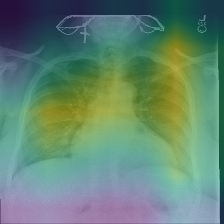

In [ ]:
heatmap = cam.compute_head_map(test_img, 3)
result = cam.overlay_heatmap(heatmap,test_resize)
cv2_imshow(result[1])

In [ ]:
meta = pd.read_csv("/content/drive/My Drive/mimic_reports/mimic-cxr-2.0.0-chexpert.csv")

In [ ]:
meta[meta['study_id'] == 52418569]

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
1822,10080695,52418569,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,0.0,NaN,1.0


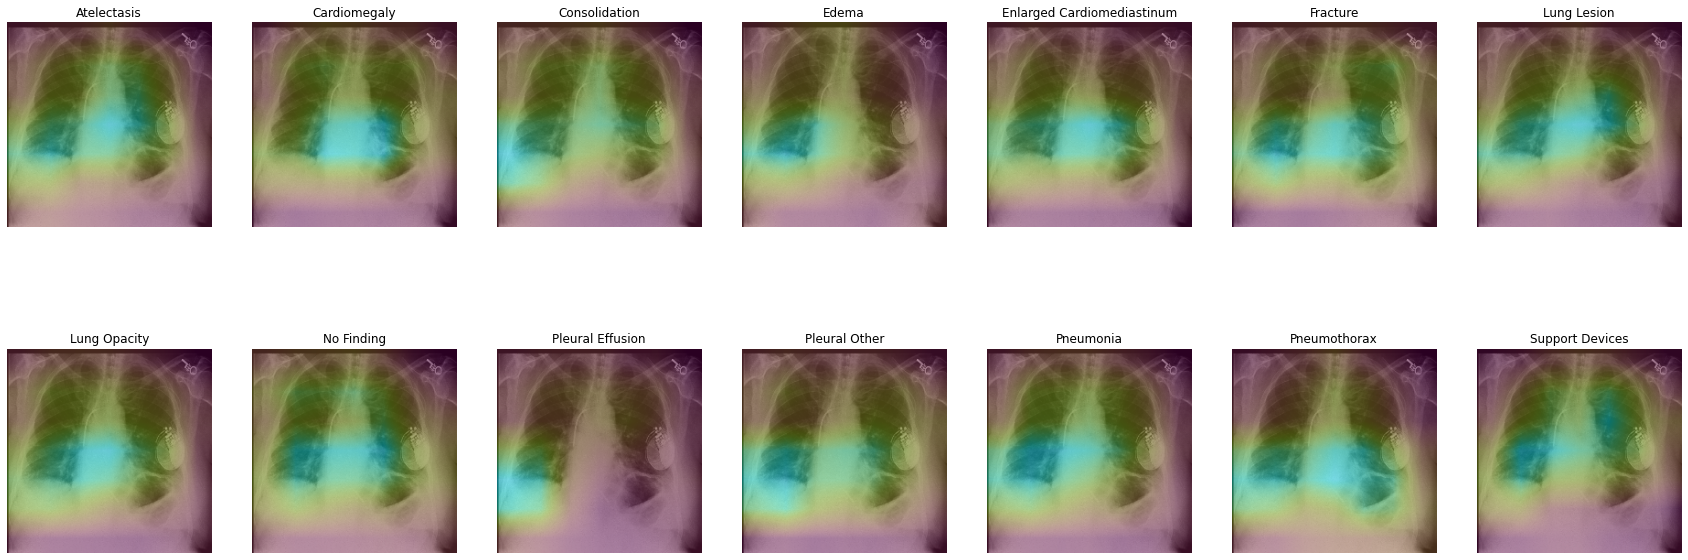

In [ ]:
fig, ax = plt.subplots(2, 7, figsize=(30,10))
fig.subplots_adjust(hspace=.5)
idx = 0
for row in ax:
  for col in row:
    col.axis('off')
    col.set_title(diseases[idx])
    heatmap = cam.compute_head_map(test_img, idx)
    result = cam.overlay_heatmap(heatmap,test_resize)
    col.imshow(result[1])
    idx+=1

### Two view

In [45]:
class GradCam:
    def __init__(self, model, layer_names=None):
      self.model=model
      self.layer_names = layer_names

    def compute_heat_map(self, img_ds, eps=1e-8):
      outputs = [self.model.get_layer(layer_name).output for layer_name in self.layer_names]
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=outputs)

      output = gradModel.predict(img_ds, workers=WK, use_multiprocessing=True, verbose=True)
    
      return output

In [50]:
# cam_multi = GradCam(model, ['relu_front', 'global_average_pooling2d_front','relu', 'global_average_pooling2d_2'])
cam_multi_front = GradCam(model, ['relu_front', 'global_average_pooling2d_6_front'])
cam_multi_side = GradCam(model, ['relu', 'global_average_pooling2d_7'])

In [47]:
def plot_tsne(data, plt_idx, idx):
  principal_result_Df = pd.DataFrame(data = data
             , columns = ['principal component 1', 'principal component 2'])
  plt.subplot(14, 4, plt_idx)
  plt.axis('off')
  plt.scatter(principal_result_Df[test_label[:,idx] == 0].iloc[:,0]
               , principal_result_Df[test_label[:,idx] == 0].iloc[:,1], c = 'b', s = 50,label="Negative")
  plt.scatter(principal_result_Df[test_label[:,idx] == 1].iloc[:,0]
               , principal_result_Df[test_label[:,idx] == 1].iloc[:,1], c = 'r', s = 50, label="Positive")
  plt.legend(loc="upper left")

270/270 [==============================] - 45s 167ms/step


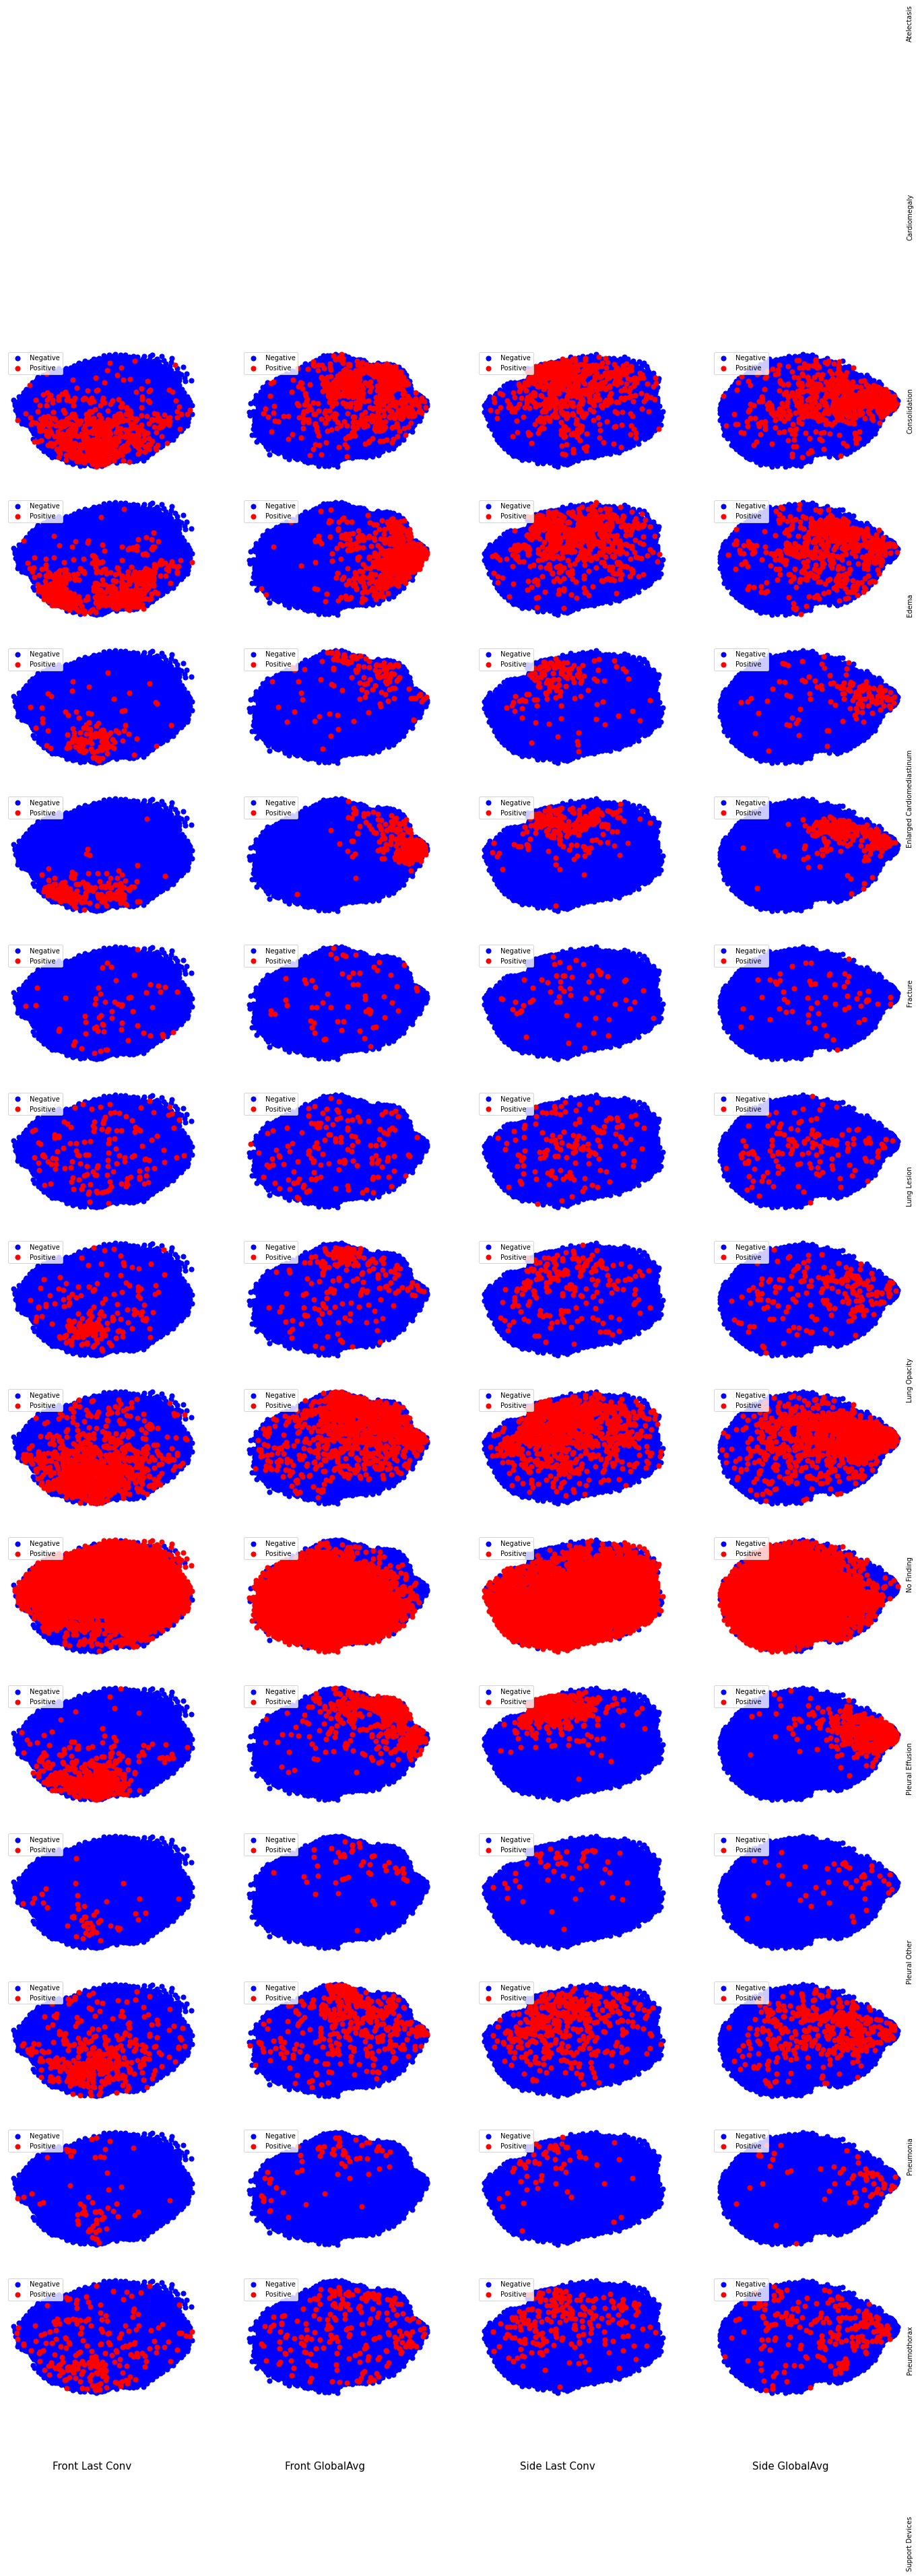

In [52]:
fig = plt.figure(figsize=(24,56))
plt.figtext(0.2,0.1,"Front Last Conv", va="center", ha="center", size=15)
plt.figtext(0.4,0.1,"Front GlobalAvg", va="center", ha="center", size=15)
plt.figtext(0.6,0.1,"Side Last Conv", va="center", ha="center", size=15)
plt.figtext(0.8,0.1,"Side GlobalAvg", va="center", ha="center", size=15)
conv_front, avg_front = cam_multi_front.compute_heat_map(test_dsrs_img_view)
conv_side, avg_side = cam_multi_side.compute_heat_map(test_dsrs_img_view)
conv_front = conv_front.reshape((conv_front.shape[0], -1))
conv_side = conv_side.reshape((conv_side.shape[0], -1))
principalComponents_result_front = TSNE().fit_transform(conv_front)
principalComponents_result_side = TSNE().fit_transform(conv_side)
principalComponents_result_front_avg = TSNE().fit_transform(avg_front)
principalComponents_result_side_avg = TSNE().fit_transform(avg_side)
for i in range(14):
  plt.figtext(0.9, 1- i/14, diseases[i], rotation=90, va='center', size=10)
  plt_idx = 4 * i + 1
  plot_tsne(principalComponents_result_front, plt_idx, i)
  plot_tsne(principalComponents_result_front_avg, plt_idx + 1, i)
  plot_tsne(principalComponents_result_side, plt_idx + 2, i)
  plot_tsne(principalComponents_result_side_avg, plt_idx + 3, i)

### Focus Branch

In [40]:
class GradCam:
    def __init__(self, model, layer_names=None):
      self.model=model
      self.layer_names = layer_names

    def compute_heat_map(self, img_ds, eps=1e-8):
      outputs = []
      for layer_name in self.layer_names:
        outputs.append(self.model.get_layer(layer_name).input)
        outputs.append(self.model.get_layer(layer_name).output)
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=outputs)

      output = gradModel.predict(img_ds, workers=WK, use_multiprocessing=True, verbose=True)
    
      return output

In [42]:
cam_local = GradCam(model, ['global_average_pooling2d_5_front'])

In [43]:
def plot_tsne(data, plt_idx, idx):
  principal_result_Df = pd.DataFrame(data = data
             , columns = ['principal component 1', 'principal component 2'])
  plt.subplot(14, 2, plt_idx)
  plt.axis('off')
  plt.scatter(principal_result_Df[test_label[:,idx] == 0].iloc[:,0]
               , principal_result_Df[test_label[:,idx] == 0].iloc[:,1], c = 'b', s = 50,label="Negative")
  plt.scatter(principal_result_Df[test_label[:,idx] == 1].iloc[:,0]
               , principal_result_Df[test_label[:,idx] == 1].iloc[:,1], c = 'r', s = 50, label="Positive")
  plt.legend(loc="upper left")

270/270 [==============================] - 46s 171ms/step


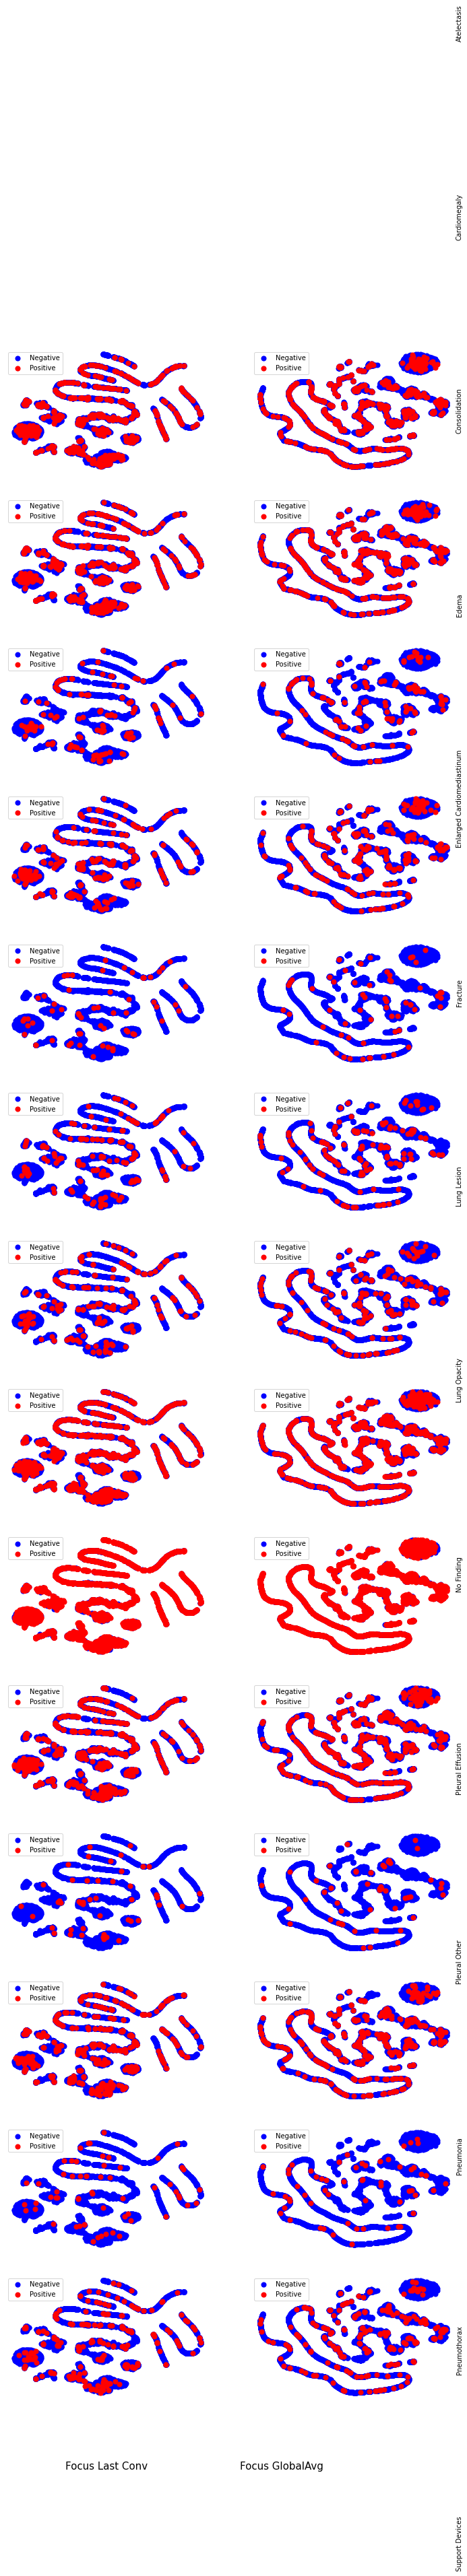

In [44]:
fig = plt.figure(figsize=(12,56))
plt.figtext(0.3,0.1,"Focus Last Conv", va="center", ha="center", size=15)
plt.figtext(0.6,0.1,"Focus GlobalAvg", va="center", ha="center", size=15)
conv, avg = cam_local.compute_heat_map(test_dsrs_img_view)
conv = conv.reshape((conv.shape[0], -1))
principalComponents_result_conv = TSNE().fit_transform(conv)
principalComponents_result_avg = TSNE().fit_transform(avg)
for i in range(14):
  plt.figtext(0.9, 1- i/14, diseases[i], rotation=90, va='center', size=10)
  plt_idx = 2 * i + 1
  plot_tsne(principalComponents_result_conv, plt_idx, i)
  plot_tsne(principalComponents_result_avg, plt_idx + 1, i)